In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
pd.options.display.float_format = '{:.4f}'.format

In [10]:
# DATA PREPROCESSING
import numpy as np
from citylearn.utilities import read_json
import os

# read the schema
dataset_name = 'citylearn_challenge_2023_phase_3_3'
root_directory = os.path.join("./data", dataset_name)
filepath = os.path.join(root_directory, 'schema.json')
schema = read_json(filepath)
schema['root_directory'] = root_directory

random_seed = 42
np.random.seed(random_seed)

buildings = list(schema['buildings'].keys())
buildings = np.random.choice(buildings, size=3, replace=False).tolist()

print("Active buildings in the schema: ")
for building in schema['buildings']:
    if building in buildings:
        schema['buildings'][building]['include'] = True
    else:
        schema['buildings'][building]['include'] = False


print("\n\nActive observations in the schema: ")
# active_observations = ['hour', 'outdoor_dry_bulb_temperature', 'outdoor_relative_humidity', 'diffuse_solar_irradiance', 'direct_solar_irradiance', 'indoor_dry_bulb_temperature', 'non_shiftable_load', 'solar_generation', 'net_electricity_consumption', 'cooling_device_cop', 'cooling_demand', 'dhw_demand', 'cooling_electricity_consumption', 'dhw_electricity_consumption', 'average_unmet_cooling_setpoint_difference', 'day_type']
active_observations = 'all'
for observation in schema['observations']:
    if active_observations == 'all':
        schema['observations'][observation]['active'] = True
        schema['observations'][observation]['shared_in_central_agent'] = True
        print(observation)
    else:
        if observation in active_observations:
            schema['observations'][observation]['active'] = True
            schema['observations'][observation]['shared_in_central_agent'] = True
            print(observation)
        else:
            schema['observations'][observation]['active'] = False
            schema['observations'][observation]['shared_in_central_agent'] = False

print("\n\nActive actions in the schema: ")
for action in schema['actions']:
    if schema['actions'][action]['active']:
        print(action)

# Set simulation timeframe (episodes)
schema['simulation_start_time_step'] = 1
lenght_of_simulation_in_days = 7
schema['simulation_end_time_step'] = lenght_of_simulation_in_days * 24

# Set custom pricing helper buildig
for building in schema['buildings']:
    if building in buildings:
        schema['buildings'][building]['type'] = 'wrappers.CustomPricingWrapper.CustomPricingBuilding'

# Set pricing data
for building in schema['buildings']:
    if building in buildings:
        schema['buildings'][building]['pricing'] = 'pricing_data_mvm_A2.csv'

# Set carbon intensity data
for building in schema['buildings']:
    if building in buildings:
        schema['buildings'][building]['carbon_intensity'] = 'carbon_intensity_HU.csv'

print("\n\nReward function: ")
print(schema['reward_function']['type'])
number_of_episodes = 1

Active buildings in the schema: 


Active observations in the schema: 
month
day_type
hour
daylight_savings_status
outdoor_dry_bulb_temperature
outdoor_dry_bulb_temperature_predicted_6h
outdoor_dry_bulb_temperature_predicted_12h
outdoor_dry_bulb_temperature_predicted_24h
outdoor_relative_humidity
outdoor_relative_humidity_predicted_6h
outdoor_relative_humidity_predicted_12h
outdoor_relative_humidity_predicted_24h
diffuse_solar_irradiance
diffuse_solar_irradiance_predicted_6h
diffuse_solar_irradiance_predicted_12h
diffuse_solar_irradiance_predicted_24h
direct_solar_irradiance
direct_solar_irradiance_predicted_6h
direct_solar_irradiance_predicted_12h
direct_solar_irradiance_predicted_24h
carbon_intensity
indoor_dry_bulb_temperature
average_unmet_cooling_setpoint_difference
indoor_relative_humidity
non_shiftable_load
solar_generation
cooling_storage_soc
heating_storage_soc
dhw_storage_soc
electrical_storage_soc
net_electricity_consumption
electricity_pricing
electricity_pricing_predicted_

In [4]:
from ipywidgets import IntProgress

def get_loader(**kwargs):
    """Returns a progress bar"""

    kwargs = {
        'value': 0,
        'min': 0,
        'max': 10,
        'description': 'Simulating:',
        'bar_style': '',
        'style': {'bar_color': 'maroon'},
        'orientation': 'horizontal',
        **kwargs
    }
    return IntProgress(**kwargs)

In [5]:
from rewardFunctions.rewardFunction2 import CustomRewardFunction

In [139]:
from citylearn.citylearn import CityLearnEnv
from agents.CustomRBC import CustomRBC

rbc_env = CityLearnEnv(schema, central_agent=True)

rbc_env.reward_function = CustomRewardFunction(rbc_env)

loader = get_loader(max=number_of_episodes*(schema['simulation_end_time_step']-1))
display(loader)

# import random
# action_map = {i: random.uniform(0, 1) for i in range(1, 25)}
action_map = {i: 0.0 for i in range(1, 25)}

rbc_model = CustomRBC(rbc_env, action_map=action_map, loader=loader)
rbc_model.learn(episodes=number_of_episodes)


kpis = rbc_model.env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value')
kpis = kpis.dropna(how='all')
display(kpis)

IntProgress(value=0, description='Simulating:', max=2876, style=ProgressStyle(bar_color='maroon'))

name,Building_1,Building_2,District
cost_function,,,
annual_normalized_unserved_energy_total,0.0000,0.0000,0.0000
annual_peak_average,NaN,NaN,1.0000
carbon_emissions_total,1.0000,1.0000,1.0000
cost_total,1.2473,1.0293,1.1383
daily_one_minus_load_factor_average,NaN,NaN,1.0000
daily_peak_average,NaN,NaN,1.0000
discomfort_delta_average,7.3992,5.6307,6.5149
discomfort_delta_maximum,13.8641,14.3858,14.1249
discomfort_delta_minimum,-0.9632,-2.8264,-1.8948


In [6]:
from citylearn.agents.q_learning import TabularQLearning
class CustomTabularQLearning(TabularQLearning):
    def __init__(
        self, env: CityLearnEnv, loader: IntProgress,
        random_seed: int = None, **kwargs
    ):
        r"""Initialize CustomRBC.

        Parameters
        ----------
        env: Mapping[str, CityLearnEnv]
            CityLearn environment instance.
        loader: IntProgress
            Progress bar.
        random_seed: int
            Random number generator reprocucibility seed for
            eqsilon-greedy action selection.
        kwargs: dict
            Parent class hyperparameters
        """

        super().__init__(env=env, random_seed=random_seed, **kwargs)
        self.loader = loader
        self.reward_history = []

    def next_time_step(self):
        if self.env.time_step == 0:
            self.reward_history.append(0)

        else:
            self.reward_history[-1] += sum(self.env.rewards[-1])

        self.loader.value += 1
        super().next_time_step()

In [8]:
from citylearn.citylearn import CityLearnEnv
from citylearn.wrappers import TabularQLearningWrapper

tql_schema = schema.copy()

print("\n\nActive observations in the schema: ")
# active_observations = ['hour', 'outdoor_dry_bulb_temperature', 'outdoor_relative_humidity', 'diffuse_solar_irradiance', 'direct_solar_irradiance', 'indoor_dry_bulb_temperature', 'non_shiftable_load', 'solar_generation', 'electrical_storage_soc', 'net_electricity_consumption', 'cooling_device_cop', 'cooling_demand', 'dhw_demand', 'cooling_electricity_consumption', 'dhw_electricity_consumption', 'average_unmet_cooling_setpoint_difference', 'day_type']
active_observations = ['hour', 'outdoor_dry_bulb_temperature', 'outdoor_relative_humidity', 'diffuse_solar_irradiance']
for observation in tql_schema['observations']:
    if active_observations == 'all':
        tql_schema['observations'][observation]['active'] = True
        tql_schema['observations'][observation]['shared_in_central_agent'] = True
        print(observation)
    else:
        if observation in active_observations:
            tql_schema['observations'][observation]['active'] = True
            tql_schema['observations'][observation]['shared_in_central_agent'] = True
            print(observation)
        else:
            tql_schema['observations'][observation]['active'] = False
            tql_schema['observations'][observation]['shared_in_central_agent'] = False


tql_env = CityLearnEnv(tql_schema, central_agent=True)

tql_env.reward_function = CustomRewardFunction(tql_env)

# observation_bins = {'hour': 24, 'outdoor_dry_bulb_temperature': 20, 'outdoor_relative_humidity': 20, 'diffuse_solar_irradiance': 20, 'direct_solar_irradiance': 20, 'indoor_dry_bulb_temperature': 20, 'non_shiftable_load': 20, 'solar_generation': 20, 'electrical_storage_soc': 20, 'net_electricity_consumption': 20, 'cooling_device_cop': 20, 'cooling_demand': 20, 'dhw_demand': 20, 'cooling_electricity_consumption': 20, 'dhw_electricity_consumption': 20, 'average_unmet_cooling_setpoint_difference': 20, 'day_type': 20}
# observation_bins = {'hour': 24, 'outdoor_dry_bulb_temperature': 10, 'outdoor_relative_humidity': 10, 'diffuse_solar_irradiance': 10, 'direct_solar_irradiance': 10, 'indoor_dry_bulb_temperature': 10, 'non_shiftable_load': 10, 'solar_generation': 10, 'electrical_storage_soc': 10, 'net_electricity_consumption': 10, 'cooling_device_cop': 10, 'cooling_demand': 10, 'dhw_demand': 10, 'cooling_electricity_consumption': 10, 'dhw_electricity_consumption': 10, 'average_unmet_cooling_setpoint_difference': 10, 'day_type': 10}
observation_bins = {'hour': 6, 'outdoor_dry_bulb_temperature': 7, 'outdoor_relative_humidity': 7, 'diffuse_solar_irradiance': 7}
action_bins = {'electrical_storage': 7, 'cooling_device': 7, 'dhw_storage': 7}


observation_bin_sizes = []
action_bin_sizes = []

for b in tql_env.buildings:
    observation_bin_sizes.append(observation_bins)
    action_bin_sizes.append(action_bins)

tql_env = TabularQLearningWrapper(
    tql_env.unwrapped,
    observation_bin_sizes=observation_bin_sizes,
    action_bin_sizes=action_bin_sizes
)

print(tql_env.action_space)
i = 3
m = tql_env.observation_space[0].n
n = tql_env.action_space[0].n
t = tql_env.time_steps - 1
tql_episodes = m*n*i/t
tql_episodes = int(tql_episodes)

loader = get_loader(max=tql_episodes*t)
display(loader)

tql_kwargs = {
    'epsilon': 1.0,
    'minimum_epsilon': 0.01,
    'epsilon_decay': 0.0001,
    'learning_rate': 0.005,
    'discount_factor': 0.99,
}

# tql_model = CustomTabularQLearning(
#     env=tql_env,
#     loader=loader,
#     random_seed=random_seed,
#     **tql_kwargs
# )

# tql_model.learn(episodes=tql_episodes)

# observations = tql_env.reset()

# dqn_actions = []
# while not tql_env.done:
#     actions, _ = tql_model.predict(observations, deterministic=True)
#     observations, _, _, _ = tql_env.step(actions) 
#     dqn_actions.append(actions)

# kpis = tql_env.evaluate()
# kpis = kpis.pivot(index='cost_function', columns='name', values='value')
# kpis = kpis.dropna(how='all')
# display(kpis)



Active observations in the schema: 
hour
outdoor_dry_bulb_temperature
outdoor_relative_humidity
diffuse_solar_irradiance
[Discrete(117649)]


IntProgress(value=0, description='Simulating:', max=1264609003, style=ProgressStyle(bar_color='maroon'))

In [8]:
from stable_baselines3.dqn import DQN

%reload_ext autoreload
import citylearn
import importlib
importlib.reload(citylearn)

from citylearn.citylearn import CityLearnEnv
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper
from helpers.custom_callback import CustomCallback
from wrappers.DQNActionWrapper import DQNActionWrapper

dqn_env = CityLearnEnv(schema, central_agent=True)

dqn_env.reward_function = CustomRewardFunction(dqn_env)

dqn_env = NormalizedObservationWrapper(dqn_env)
dqn_env = StableBaselines3Wrapper(dqn_env)

action_bins = {'electrical_storage': 20, 'dhw_storage': 20, 'cooling_device': 20}
action_bin_sizes = []
for b in dqn_env.buildings:
    action_bin_sizes.append(action_bins)

dqn_env = DQNActionWrapper(dqn_env, action_bin_sizes)

total_timesteps = number_of_episodes * (dqn_env.time_steps - 1)
dqn_model = DQN("MlpPolicy", dqn_env, seed=random_seed, learning_starts=total_timesteps/3, learning_rate=0.001)

dqn_callback = CustomCallback(env=dqn_env, total_timesteps=total_timesteps)
dqn_model.learn(total_timesteps=total_timesteps, progress_bar=True, callback=dqn_callback)

observations = dqn_env.reset()

dqn_actions = []
while not dqn_env.done:
    actions, _ = dqn_model.predict(observations, deterministic=True)
    observations, _, _, _ = dqn_env.step(actions) 
    dqn_actions.append(actions)

# print cost functions at the end of episode
kpis = dqn_env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value')
kpis = kpis.dropna(how='all')
display(kpis)

Output()

[7, 7, 7, 7, 7, 7]

[6, 1, 6, 5, 5, 0]

[7, 7, 7, 7, 7, 7]

[1, 6, 1, 2, 3, 2]

[7, 7, 7, 7, 7, 7]

[6, 2, 4, 4, 6, 1]

[7, 7, 7, 7, 7, 7]

[0, 1, 4, 1, 6, 5]

[7, 7, 7, 7, 7, 7]

[3, 0, 1, 6, 0, 5]

[7, 7, 7, 7, 7, 7]

[0, 5, 0, 4, 3, 4]

[7, 7, 7, 7, 7, 7]

[1, 1, 6, 2, 3, 1]

[7, 7, 7, 7, 7, 7]

[5, 5, 0, 0, 1, 1]

[7, 7, 7, 7, 7, 7]

[3, 2, 3, 5, 5, 4]

[7, 7, 7, 7, 7, 7]

[6, 3, 1, 4, 0, 6]

[7, 7, 7, 7, 7, 7]

[2, 5, 6, 1, 4, 2]

[7, 7, 7, 7, 7, 7]

[4, 6, 0, 2, 1, 6]

[7, 7, 7, 7, 7, 7]

[0, 2, 0, 1, 4, 4]

[[0, 1, 2, 3, 4, 5, 6], [0, 1, 2, 3, 4, 5, 6], [0, 1, 2, 3, 4, 5, 6], [0, 1, 2, 3, 4, 5, 6], [0, 1, 2, 3, 4, 5, 6], [0, 1, 2, 3, 4, 5, 6]]


[7, 7, 7, 7, 7, 7]

[5, 2, 3, 4, 2, 1]

[7, 7, 7, 7, 7, 7]

[4, 6, 4, 5, 5, 5]

[7, 7, 7, 7, 7, 7]

[4, 2, 6, 0, 3, 6]

[7, 7, 7, 7, 7, 7]

[6, 0, 2, 0, 4, 3]

[7, 7, 7, 7, 7, 7]

[5, 6, 4, 3, 6, 0]

[7, 7, 7, 7, 7, 7]

[2, 0, 1, 4, 1, 3]

[7, 7, 7, 7, 7, 7]

[2, 6, 2, 2, 5, 5]

[7, 7, 7, 7, 7, 7]

[2, 0, 6, 3, 5, 5]

[7, 7, 7, 7, 7, 7]

[2, 2, 6, 6, 1, 0]

[7, 7, 7, 7, 7, 7]

[6, 1, 1, 0, 4, 1]

[7, 7, 7, 7, 7, 7]

[1, 6, 6, 0, 4, 2]

[7, 7, 7, 7, 7, 7]

[4, 6, 1, 2, 0, 1]

[7, 7, 7, 7, 7, 7]

[5, 2, 3, 4, 6, 6]

[7, 7, 7, 7, 7, 7]

[2, 0, 2, 4, 4, 3]

[7, 7, 7, 7, 7, 7]

[5, 3, 0, 6, 3, 2]

[7, 7, 7, 7, 7, 7]

[6, 0, 6, 2, 0, 5]

[7, 7, 7, 7, 7, 7]

[0, 5, 2, 2, 4, 2]

[7, 7, 7, 7, 7, 7]

[3, 1, 5, 2, 4, 6]

[7, 7, 7, 7, 7, 7]

[4, 3, 0, 6, 4, 0]

[7, 7, 7, 7, 7, 7]

[5, 4, 0, 4, 3, 3]

[7, 7, 7, 7, 7, 7]

[4, 3, 2, 3, 6, 5]

[7, 7, 7, 7, 7, 7]

[0, 2, 2, 3, 0, 1]

[7, 7, 7, 7, 7, 7]

[3, 2, 1, 1, 2, 2]

[7, 7, 7, 7, 7, 7]

[0, 6, 3, 2, 5, 0]

[7, 7, 7, 7, 7, 7]

[0, 1, 6, 5, 6, 2]

[7, 7, 7, 7, 7, 7]

[4, 6, 0, 0, 0, 5]

[7, 7, 7, 7, 7, 7]

[3, 1, 2, 5, 4, 4]

[7, 7, 7, 7, 7, 7]

[6, 1, 5, 6, 3, 4]

[7, 7, 7, 7, 7, 7]

[6, 5, 0, 5, 6, 6]

[7, 7, 7, 7, 7, 7]

[2, 3, 2, 5, 1, 6]

[7, 7, 7, 7, 7, 7]

[1, 1, 5, 1, 1, 5]

[7, 7, 7, 7, 7, 7]

[0, 4, 6, 3, 6, 1]

[7, 7, 7, 7, 7, 7]

[4, 0, 1, 1, 5, 2]

[7, 7, 7, 7, 7, 7]

[2, 2, 4, 3, 1, 2]

[7, 7, 7, 7, 7, 7]

[6, 2, 4, 1, 1, 0]

[7, 7, 7, 7, 7, 7]

[6, 3, 5, 4, 5, 5]

[7, 7, 7, 7, 7, 7]

[4, 1, 4, 3, 3, 5]

[7, 7, 7, 7, 7, 7]

[6, 0, 6, 2, 4, 5]

[7, 7, 7, 7, 7, 7]

[3, 1, 4, 2, 3, 3]

[7, 7, 7, 7, 7, 7]

[1, 3, 2, 5, 4, 1]

[7, 7, 7, 7, 7, 7]

[5, 1, 1, 5, 0, 4]

[7, 7, 7, 7, 7, 7]

[1, 3, 0, 4, 5, 3]

[7, 7, 7, 7, 7, 7]

[0, 2, 2, 2, 5, 2]

[7, 7, 7, 7, 7, 7]

[5, 0, 4, 4, 4, 4]

[7, 7, 7, 7, 7, 7]

[5, 0, 4, 4, 4, 4]

[7, 7, 7, 7, 7, 7]

[5, 0, 4, 4, 4, 4]

[7, 7, 7, 7, 7, 7]

[5, 0, 4, 4, 4, 4]

[7, 7, 7, 7, 7, 7]

[0, 3, 5, 1, 4, 3]

[7, 7, 7, 7, 7, 7]

[5, 0, 4, 4, 4, 4]

[7, 7, 7, 7, 7, 7]

[5, 0, 4, 4, 4, 4]

[7, 7, 7, 7, 7, 7]

[0, 1, 6, 0, 5, 2]

[7, 7, 7, 7, 7, 7]

[2, 0, 3, 0, 2, 1]

[7, 7, 7, 7, 7, 7]

[2, 6, 0, 1, 1, 6]

[7, 7, 7, 7, 7, 7]

[7, 7, 7, 7, 7, 7]

[2, 2, 1, 1, 5, 0]

[7, 7, 7, 7, 7, 7]

[2, 3, 3, 5, 1, 6]

[7, 7, 7, 7, 7, 7]

[2, 0, 3, 0, 2, 1]

[7, 7, 7, 7, 7, 7]

[6, 5, 3, 5, 5, 5]

[7, 7, 7, 7, 7, 7]

[2, 1, 2, 5, 3, 0]

[7, 7, 7, 7, 7, 7]

[6, 5, 3, 5, 5, 5]

[7, 7, 7, 7, 7, 7]

[6, 5, 3, 5, 5, 5]

[7, 7, 7, 7, 7, 7]

[2, 2, 1, 1, 5, 0]

[7, 7, 7, 7, 7, 7]

[6, 5, 3, 5, 5, 5]

[7, 7, 7, 7, 7, 7]

[6, 5, 3, 5, 5, 5]

[7, 7, 7, 7, 7, 7]

[0, 2, 5, 6, 2, 2]

[7, 7, 7, 7, 7, 7]

[0, 2, 5, 6, 2, 2]

[7, 7, 7, 7, 7, 7]

[5, 0, 4, 0, 4, 3]

[7, 7, 7, 7, 7, 7]

[5, 0, 4, 0, 4, 3]

[7, 7, 7, 7, 7, 7]

[4, 4, 0, 5, 2, 4]

[7, 7, 7, 7, 7, 7]

[0, 2, 5, 1, 5, 1]

[7, 7, 7, 7, 7, 7]

[5, 0, 4, 0, 4, 3]

[7, 7, 7, 7, 7, 7]

[4, 4, 0, 5, 2, 4]

[7, 7, 7, 7, 7, 7]

[5, 0, 4, 0, 4, 3]

[7, 7, 7, 7, 7, 7]

[4, 4, 0, 5, 2, 4]

[7, 7, 7, 7, 7, 7]

[6, 1, 1, 2, 4, 2]

[7, 7, 7, 7, 7, 7]

[5, 0, 4, 0, 4, 3]

[7, 7, 7, 7, 7, 7]

[6, 5, 3, 5, 5, 5]

[7, 7, 7, 7, 7, 7]

[6, 5, 3, 5, 5, 5]

[7, 7, 7, 7, 7, 7]

[2, 0, 3, 0, 2, 1]

[7, 7, 7, 7, 7, 7]

[2, 0, 3, 0, 2, 1]

[7, 7, 7, 7, 7, 7]

[5, 3, 5, 4, 2, 3]

[7, 7, 7, 7, 7, 7]

[4, 4, 3, 1, 2, 5]

[7, 7, 7, 7, 7, 7]

[0, 2, 5, 6, 2, 2]

[7, 7, 7, 7, 7, 7]

[0, 2, 5, 6, 2, 2]

[7, 7, 7, 7, 7, 7]

[5, 3, 5, 4, 2, 3]

[7, 7, 7, 7, 7, 7]

[0, 2, 5, 6, 2, 2]

[7, 7, 7, 7, 7, 7]

[6, 2, 2, 1, 0, 3]

[7, 7, 7, 7, 7, 7]

[0, 2, 5, 6, 2, 2]

[7, 7, 7, 7, 7, 7]

[6, 2, 2, 2, 3, 2]

[7, 7, 7, 7, 7, 7]

[0, 2, 5, 6, 2, 2]

[7, 7, 7, 7, 7, 7]

[4, 4, 0, 5, 2, 4]

[7, 7, 7, 7, 7, 7]

[0, 4, 5, 3, 4, 5]

[7, 7, 7, 7, 7, 7]

[0, 4, 5, 3, 4, 5]

[7, 7, 7, 7, 7, 7]

[0, 2, 5, 6, 2, 2]

[7, 7, 7, 7, 7, 7]

[4, 4, 0, 5, 2, 4]

[7, 7, 7, 7, 7, 7]

[6, 1, 1, 2, 4, 2]

[7, 7, 7, 7, 7, 7]

[6, 1, 1, 2, 4, 2]

[7, 7, 7, 7, 7, 7]

[6, 1, 1, 2, 4, 2]

[7, 7, 7, 7, 7, 7]

[5, 6, 0, 1, 1, 1]

[7, 7, 7, 7, 7, 7]

[6, 1, 1, 2, 4, 2]

[7, 7, 7, 7, 7, 7]

[6, 1, 1, 2, 4, 2]

[7, 7, 7, 7, 7, 7]

[5, 6, 0, 1, 1, 1]

[7, 7, 7, 7, 7, 7]

[7, 7, 7, 7, 7, 7]

[5, 2, 6, 1, 6, 3]

[7, 7, 7, 7, 7, 7]

[0, 0, 3, 6, 4, 6]

[7, 7, 7, 7, 7, 7]

[5, 6, 5, 6, 6, 5]

[7, 7, 7, 7, 7, 7]

[0, 0, 3, 6, 4, 6]

[7, 7, 7, 7, 7, 7]

[0, 2, 5, 6, 2, 2]

[7, 7, 7, 7, 7, 7]

[0, 2, 5, 6, 2, 2]

[7, 7, 7, 7, 7, 7]

[0, 2, 5, 6, 2, 2]

[7, 7, 7, 7, 7, 7]

[2, 0, 2, 5, 2, 5]

[7, 7, 7, 7, 7, 7]

[6, 1, 0, 1, 0, 5]

[7, 7, 7, 7, 7, 7]

[2, 0, 2, 5, 2, 5]

[7, 7, 7, 7, 7, 7]

[2, 0, 2, 5, 2, 5]

[7, 7, 7, 7, 7, 7]

[6, 4, 6, 5, 2, 3]

[7, 7, 7, 7, 7, 7]

[6, 2, 2, 1, 0, 3]

[7, 7, 7, 7, 7, 7]

[6, 1, 0, 1, 0, 5]

[7, 7, 7, 7, 7, 7]

[6, 0, 4, 3, 2, 6]

[7, 7, 7, 7, 7, 7]

[2, 1, 1, 2, 0, 1]

[7, 7, 7, 7, 7, 7]

[6, 0, 4, 3, 2, 6]

[7, 7, 7, 7, 7, 7]

[7, 7, 7, 7, 7, 7]

[6, 2, 2, 1, 1, 3]

[7, 7, 7, 7, 7, 7]

[6, 2, 2, 1, 1, 3]

[7, 7, 7, 7, 7, 7]

[6, 2, 2, 1, 1, 3]

[7, 7, 7, 7, 7, 7]

[6, 2, 2, 1, 1, 3]

[7, 7, 7, 7, 7, 7]

[3, 6, 3, 1, 2, 5]

[7, 7, 7, 7, 7, 7]

[6, 2, 2, 1, 1, 3]

[7, 7, 7, 7, 7, 7]

[6, 2, 2, 1, 1, 3]

[7, 7, 7, 7, 7, 7]

[3, 6, 3, 1, 2, 5]

[7, 7, 7, 7, 7, 7]

[2, 5, 4, 2, 2, 5]

[7, 7, 7, 7, 7, 7]

[2, 5, 4, 2, 2, 5]

[7, 7, 7, 7, 7, 7]

[2, 5, 4, 2, 2, 5]

[7, 7, 7, 7, 7, 7]

[2, 5, 4, 2, 2, 5]

[7, 7, 7, 7, 7, 7]

[2, 5, 4, 2, 2, 5]

[7, 7, 7, 7, 7, 7]

[2, 5, 4, 2, 2, 5]

[7, 7, 7, 7, 7, 7]

[2, 5, 4, 2, 2, 5]

[7, 7, 7, 7, 7, 7]

[2, 1, 5, 6, 3, 1]

[7, 7, 7, 7, 7, 7]

[2, 1, 5, 6, 3, 1]

[7, 7, 7, 7, 7, 7]

[3, 2, 6, 0, 1, 5]

[7, 7, 7, 7, 7, 7]

[3, 2, 6, 0, 1, 5]

[7, 7, 7, 7, 7, 7]

[3, 2, 6, 0, 1, 5]

[7, 7, 7, 7, 7, 7]

[4, 4, 6, 5, 3, 3]

[7, 7, 7, 7, 7, 7]

[1, 2, 5, 4, 5, 0]

[7, 7, 7, 7, 7, 7]

[1, 2, 5, 4, 5, 0]

[7, 7, 7, 7, 7, 7]

[7, 7, 7, 7, 7, 7]

[6, 2, 2, 1, 1, 3]

[7, 7, 7, 7, 7, 7]

[4, 0, 6, 3, 4, 4]

[7, 7, 7, 7, 7, 7]

[1, 3, 5, 4, 1, 0]

[7, 7, 7, 7, 7, 7]

[2, 5, 4, 2, 2, 5]

[7, 7, 7, 7, 7, 7]

[1, 3, 5, 4, 1, 0]

[7, 7, 7, 7, 7, 7]

[1, 3, 5, 4, 1, 0]

[7, 7, 7, 7, 7, 7]

[1, 3, 5, 4, 1, 0]

[7, 7, 7, 7, 7, 7]

[2, 5, 4, 2, 2, 5]

[7, 7, 7, 7, 7, 7]

[1, 1, 4, 0, 0, 1]

[7, 7, 7, 7, 7, 7]
[1, 1, 4, 0, 0, 1]
[7, 7, 7, 7, 7, 7]
[2, 5, 1, 0, 6, 6]
[7, 7, 7, 7, 7, 7]
[3, 6, 3, 1, 2, 5]
[7, 7, 7, 7, 7, 7]
[2, 2, 6, 0, 0, 3]
[7, 7, 7, 7, 7, 7]
[3, 6, 3, 1, 2, 5]
[7, 7, 7, 7, 7, 7]
[2, 2, 6, 0, 0, 3]
[7, 7, 7, 7, 7, 7]
[0, 5, 4, 6, 4, 2]
[7, 7, 7, 7, 7, 7]
[0, 5, 4, 6, 4, 2]
[7, 7, 7, 7, 7, 7]
[0, 5, 4, 6, 4, 2]
[7, 7, 7, 7, 7, 7]
[2, 2, 6, 0, 0, 3]
[7, 7, 7, 7, 7, 7]
[3, 0, 2, 3, 5, 6]
[7, 7, 7, 7, 7, 7]
[4, 3, 4, 5, 2, 5]
[7, 7, 7, 7, 7, 7]
[4, 3, 4, 2, 6, 0]
[7, 7, 7, 7, 7, 7]
[4, 3, 4, 2, 6, 0]
[7, 7, 7, 7, 7, 7]
[2, 1, 1, 2, 0, 1]
[7, 7, 7, 7, 7, 7]
[1, 1, 6, 2, 2, 2]
[7, 7, 7, 7, 7, 7]
[4, 0, 6, 3, 4, 4]
[7, 7, 7, 7, 7, 7]
[4, 0, 6, 3, 4, 4]
[7, 7, 7, 7, 7, 7]
[4, 0, 6, 3, 4, 4]
[7, 7, 7, 7, 7, 7]
[4, 0, 6, 3, 4, 4]
[7, 7, 7, 7, 7, 7]
[2, 1, 1, 2, 0, 1]
[7, 7, 7, 7, 7, 7]
[4, 0, 6, 3, 4, 4]
[7, 7, 7, 7, 7, 7]
[2, 1, 1, 2, 0, 1]
[7, 7, 7, 7, 7, 7]
[2, 3, 4, 0, 2, 5]
[7, 7, 7, 7, 7, 7]
[2, 1, 1, 2, 0, 1]
[7, 7, 7, 7, 7, 7]
[2, 1, 1, 2, 0, 1]
[7, 7, 7, 7,

name,Building_1,Building_2,District
cost_function,,,
annual_normalized_unserved_energy_total,0.0000,0.0000,0.0000
annual_peak_average,NaN,NaN,1.7870
carbon_emissions_total,3.5452,4.3555,3.9503
cost_total,5.2805,4.6863,4.9834
daily_one_minus_load_factor_average,NaN,NaN,0.7384
daily_peak_average,NaN,NaN,2.0493
discomfort_delta_average,-10.6930,-5.9670,-8.3300
discomfort_delta_maximum,0.0010,1.4064,0.7037
discomfort_delta_minimum,-16.5294,-13.6380,-15.0837


In [137]:
%reload_ext autoreload
from stable_baselines3.sac import SAC
from citylearn.citylearn import CityLearnEnv
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper
from helpers.custom_callback import CustomCallback
from stable_baselines3.common.noise import NormalActionNoise
from typing import Callable

sac_env = CityLearnEnv(schema, central_agent=True)

sac_env.reward_function = CustomRewardFunction(sac_env)

sac_env = NormalizedObservationWrapper(sac_env)
sac_env = StableBaselines3Wrapper(sac_env)

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

n_actions = sac_env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
sac_model = SAC("MlpPolicy", sac_env, seed=random_seed, learning_rate=linear_schedule(0.01), action_noise=action_noise)

total_timesteps = number_of_episodes * (sac_env.time_steps - 1)
sac_callback = CustomCallback(sac_env, total_timesteps=total_timesteps)
sac_model.learn(total_timesteps=total_timesteps, progress_bar=True, callback=sac_callback)

observations = sac_env.reset()
sac_actions = []

while not sac_env.done:
    actions, _ = sac_model.predict(observations, deterministic=True)
    observations, _, _, _ = sac_env.step(actions)
    sac_actions.append(actions)

# print cost functions at the end of episode
kpis = sac_env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value')
kpis = kpis.dropna(how='all')
display(kpis)

Output()

name,Building_1,Building_2,District
cost_function,,,
annual_normalized_unserved_energy_total,0.0000,0.0000,0.0000
annual_peak_average,NaN,NaN,1.0319
carbon_emissions_total,1.0137,1.0008,1.0073
cost_total,1.5503,1.3958,1.4731
daily_one_minus_load_factor_average,NaN,NaN,1.0011
daily_peak_average,NaN,NaN,1.0365
discomfort_delta_average,2.5129,1.5760,2.0445
discomfort_delta_maximum,9.4984,8.8637,9.1810
discomfort_delta_minimum,-6.6762,-4.0641,-5.3701


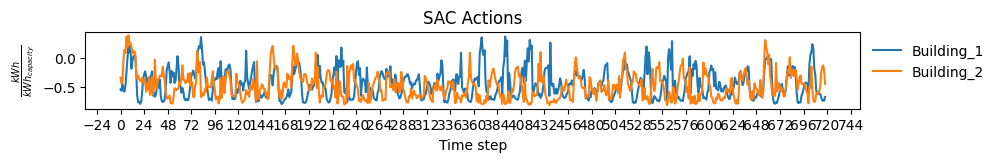

In [140]:
from typing import List
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
%matplotlib inline

def plot_actions(actions_list: List[List[float]], title: str) -> plt.Figure:
    """Plots action time series for different buildings

    Parameters
    ----------
    actions_list: List[List[float]]
        List of actions where each element with index, i,
        in list is a list of the actions for different buildings
        taken at time step i.
    title: str
        Plot axes title

    Returns
    -------
    fig: plt.Figure
        Figure with plotted axes

    """

    fig, ax = plt.subplots(1, 1, figsize=(10, 1))
    columns = [b.name for b in sac_env.buildings]
    actions_list = [[inner[1], inner[4]] for inner in actions_list]
    plot_data = pd.DataFrame(actions_list, columns=columns)
    x = list(range(plot_data.shape[0]))

    for c in plot_data.columns:
        y = plot_data[c].tolist()
        ax.plot(x, y, label=c)

    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)
    ax.set_xlabel('Time step')
    ax.set_ylabel(r'$\frac{kWh}{kWh_{capacity}}$')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
    ax.set_title(title)

    return fig

fig = plot_actions(sac_actions, 'SAC Actions')
plt.show()

In [54]:
from stable_baselines3.a2c import A2C
from citylearn.citylearn import CityLearnEnv
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper
from helpers.custom_callback import CustomCallback

a2c_env = CityLearnEnv(schema, central_agent=True)

a2c_env.reward_function = CustomRewardFunction(a2c_env)

a2c_env = NormalizedObservationWrapper(a2c_env)
a2c_env = StableBaselines3Wrapper(a2c_env)

a2c_model = A2C("MlpPolicy", a2c_env, seed=random_seed)

total_timesteps = number_of_episodes * sac_env.time_steps
print(total_timesteps)
a2c_callback = CustomCallback(a2c_env, total_timesteps=total_timesteps)
a2c_model.learn(total_timesteps=a2c_env.time_steps * number_of_episodes, progress_bar=True, callback=a2c_callback)

observations = a2c_env.reset()

while not a2c_env.done:
    actions, _ = a2c_model.predict(observations, deterministic=True)
    observations, _, _, _ = a2c_env.step(actions) 

# print cost functions at the end of episode
kpis = a2c_env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value')
kpis = kpis.dropna(how='all')
display(kpis)

Output()

840


: 

In [ ]:
from stable_baselines3.ddpg import DDPG
from citylearn.citylearn import CityLearnEnv
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper
from stable_baselines3.common.noise import NormalActionNoise
from helpers.custom_callback import CustomCallback

ddpg_env = CityLearnEnv(schema, central_agent=True)

ddpg_env.reward_function = CustomRewardFunction(ddpg_env)

ddpg_env = NormalizedObservationWrapper(ddpg_env)
ddpg_env = StableBaselines3Wrapper(ddpg_env)

n_actions = ddpg_env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
ddpg_model = DDPG("MlpPolicy", ddpg_env, action_noise=action_noise, seed=random_seed)

total_timesteps = number_of_episodes * ddpg_env.time_steps
print(total_timesteps)
ddpg_callback = CustomCallback(ddpg_env, total_timesteps=total_timesteps)
ddpg_model.learn(total_timesteps=total_timesteps, progress_bar=True, callback=ddpg_callback)

observations = ddpg_env.reset()

while not ddpg_env.done:
    actions, _ = ddpg_model.predict(observations, deterministic=True)
    observations, _, _, _ = ddpg_env.step(actions) 

# print cost functions at the end of episode
kpis = ddpg_env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value')
kpis = kpis.dropna(how='all')
display(kpis)

Output()

4200


name,Building_1,Building_2,District
cost_function,,,
annual_normalized_unserved_energy_total,0.000000,-2.123242e-09,-1.061621e-09
annual_peak_average,NaN,NaN,1.116373e+00
carbon_emissions_total,1.618137,1.036025e+00,1.327081e+00
cost_total,1.695197,9.678851e-01,1.331541e+00
daily_one_minus_load_factor_average,NaN,NaN,9.926849e-01
daily_peak_average,NaN,NaN,1.264444e+00
discomfort_delta_average,-3.466800,1.226908e+00,-1.119946e+00
discomfort_delta_maximum,2.373598,9.422108e+00,5.897853e+00
discomfort_delta_minimum,-13.508899,-3.701527e+00,-8.605213e+00


In [ ]:
from stable_baselines3.td3 import TD3
from citylearn.citylearn import CityLearnEnv
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper
from stable_baselines3.common.noise import NormalActionNoise
from helpers.custom_callback import CustomCallback

td3_env = CityLearnEnv(schema, central_agent=True)

td3_env.reward_function = CustomRewardFunction(td3_env)

td3_env = NormalizedObservationWrapper(td3_env)
td3_env = StableBaselines3Wrapper(td3_env)

n_actions = td3_env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
td3_model = TD3("MlpPolicy", td3_env, action_noise=action_noise, seed=random_seed)

total_timesteps = number_of_episodes * td3_env.time_steps
print(total_timesteps)
td3_callback = CustomCallback(td3_env, total_timesteps=total_timesteps)
td3_model.learn(total_timesteps=total_timesteps, progress_bar=True, callback=td3_callback)

observations = td3_env.reset()

while not td3_env.done:
    actions, _ = td3_model.predict(observations, deterministic=True)
    observations, _, _, _ = td3_env.step(actions) 

# print cost functions at the end of episode
kpis = td3_env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value')
kpis = kpis.dropna(how='all')
display(kpis)

Output()

4200


name,Building_1,Building_2,District
cost_function,,,
annual_normalized_unserved_energy_total,0.000000,-2.051098e-10,-1.025549e-10
annual_peak_average,NaN,NaN,1.273999e+00
carbon_emissions_total,1.731331,1.769198e+00,1.750264e+00
cost_total,1.917065,1.757433e+00,1.837249e+00
daily_one_minus_load_factor_average,NaN,NaN,1.006315e+00
daily_peak_average,NaN,NaN,1.649666e+00
discomfort_delta_average,-2.623566,-5.268186e-01,-1.575192e+00
discomfort_delta_maximum,4.289593,2.533783e+00,3.411688e+00
discomfort_delta_minimum,-12.406586,-6.698103e+00,-9.552344e+00


In [ ]:
from stable_baselines3.ppo import PPO
from citylearn.citylearn import CityLearnEnv
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper
from helpers.custom_callback import CustomCallback

ppo_env = CityLearnEnv(schema, central_agent=True)

ppo_env.reward_function = CustomRewardFunction(ppo_env)

ppo_env = NormalizedObservationWrapper(ppo_env)
ppo_env = StableBaselines3Wrapper(ppo_env)

ppo_model = PPO("MlpPolicy", ppo_env, seed=random_seed)

total_timesteps = number_of_episodes * ppo_env.time_steps
print(total_timesteps)
ppo_callback = CustomCallback(env=ppo_env, total_timesteps=total_timesteps)
ppo_model.learn(total_timesteps=total_timesteps, progress_bar=True, callback=ppo_callback)

observations = ppo_env.reset()

while not ppo_env.done:
    actions, _ = ppo_model.predict(observations, deterministic=True)
    observations, _, _, _ = ppo_env.step(actions) 

# print cost functions at the end of episode
kpis = ppo_env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value')
kpis = kpis.dropna(how='all')
display(kpis)

Output()

name,Building_1,Building_2,District
cost_function,,,
annual_normalized_unserved_energy_total,0.000000,0.000000,0.000000
annual_peak_average,NaN,NaN,0.952686
carbon_emissions_total,0.784446,0.894430,0.839438
cost_total,0.782694,0.877796,0.830245
daily_one_minus_load_factor_average,NaN,NaN,1.051987
daily_peak_average,NaN,NaN,0.950128
discomfort_delta_average,3.899387,1.492367,2.695877
discomfort_delta_maximum,7.572870,9.439117,8.505994
discomfort_delta_minimum,-0.963158,-2.826351,-1.894754


In [73]:
from typing import List
import matplotlib.pyplot as plt

def plot_rewards(ax: plt.Axes, rewards: List[float], title: str) -> plt.Axes:
    """Plots rewards over training episodes.

    Parameters
    ----------
    rewards: List[float]
        List of reward sum per episode.
    title: str
        Plot axes title

    Returns
    -------
    ax: plt.Axes
        Plotted axes
    """

    ax.plot(rewards)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')
    ax.set_title(title)

    return ax

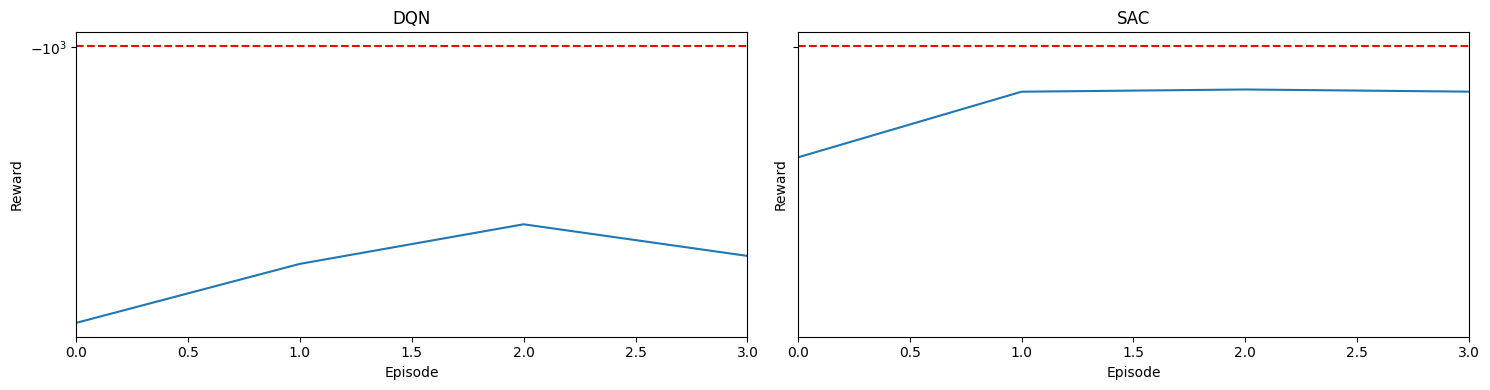

In [145]:
%matplotlib inline

rewards = {
    'DQN': dqn_callback.reward_history[:number_of_episodes],
    'SAC': sac_callback.reward_history[:number_of_episodes],
    # 'A2C': a2c_callback.reward_history[:number_of_episodes],
    # 'DDPG': ddpg_callback.reward_history[:number_of_episodes],
    # 'TD3': td3_callback.reward_history[:number_of_episodes],
    # 'PPO': ppo_callback.reward_history[:number_of_episodes]
}

min_value = min(min(rewards[key]) for key in rewards)
max_value = max(max(rewards[key]) for key in rewards)

round_factor = 10 ** np.floor(np.log10(max(abs(min_value), abs(max_value))))
min_value = np.floor(min_value / round_factor) * round_factor
max_value = np.ceil(max_value / round_factor) * round_factor

fig, axs = plt.subplots(1, len(rewards), figsize=(15, 4), sharey=True)

rbc_rewards = [episode_reward['sum'][0] for episode_reward in rbc_model.env.episode_rewards]
for ax, (k, v) in zip(fig.axes, rewards.items()):
    ax.plot(rbc_rewards, 'r--', label='RBC')
    ax = plot_rewards(ax, v, k)
    # ax.set_ylim(min_value, max_value)
    ax.set_xlim(0, number_of_episodes - 1)
    ax.set_yscale(value='symlog')

plt.tight_layout()
plt.show()

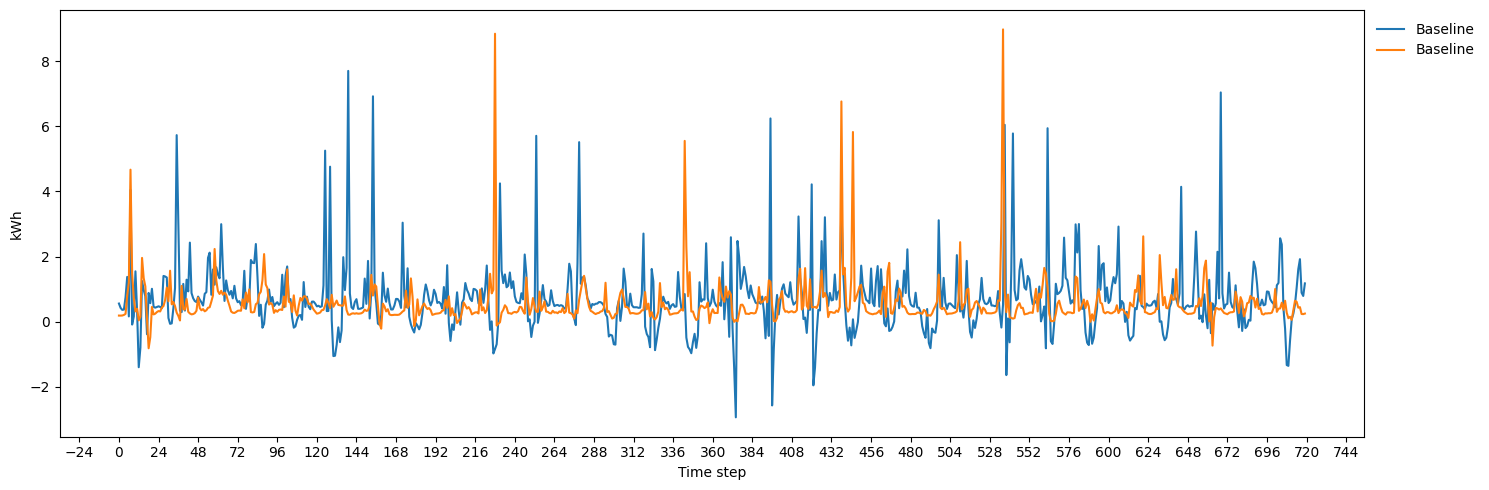

In [146]:
import matplotlib.ticker as ticker
%matplotlib inline

envs = {
    # 'RBC': rbc_env,
    # 'DQN': dqn_env,
    'SAC': sac_env,
    # 'A2C': a2c_env,
    # 'DDPG': ddpg_env,
    # 'TD3': td3_env,
    # 'PPO': ppo_env
}

figsize = (15.0, 5)
fig, ax = plt.subplots(1, 1, figsize=figsize)

for k, v in envs.items():
    y = v.net_electricity_consumption
    x = range(len(y))
    # ax.plot(x, y, label=k)

y = v.buildings[0].net_electricity_consumption
ax.plot(x, y, label='Baseline')
y = v.buildings[1].net_electricity_consumption
ax.plot(x, y, label='Baseline')
# y = v.solar_generation
# ax.plot(x, y, label='Solar')
# y = v.electrical_storage_electricity_consumption
# ax.plot(x, y, label='Battery')
# # y = v.energy_from_cooling_device
# # ax.plot(x, y, label='Heat pump')
# # y = v.dhw_electricity_consumption
# # ax.plot(x, y, label='DHW consumption')
# y = v.dhw_storage_electricity_consumption
# ax.plot(x, y, label='DHW storage')

ax.set_xlabel('Time step')
ax.set_ylabel('kWh')
# ax.set_xlim(120, 160)
ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)

plt.tight_layout()

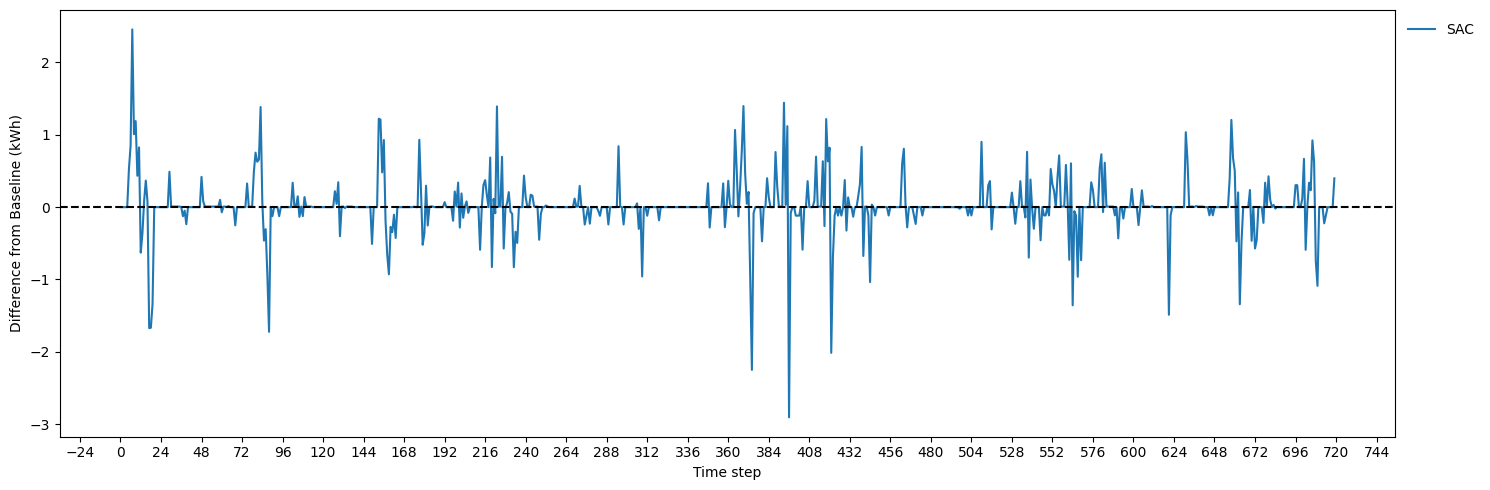

In [149]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

envs = {
    'SAC': sac_env,
    # 'DQN': dqn_env,
    # 'A2C': a2c_env,
    # 'DDPG': ddpg_env,
    # 'TD3': td3_env,
    # 'PPO': ppo_env
}

figsize = (15.0, 5)
fig, ax = plt.subplots(1, 1, figsize=figsize)

baseline = sac_env.net_electricity_consumption_without_storage  # Assuming 'ppo_env' is your baseline environment

for k, v in envs.items():
    y_difference = [y - base for y, base in zip(v.net_electricity_consumption, baseline)]
    x = range(len(y_difference))
    ax.plot(x, y_difference, label=k)

ax.axhline(y=0, color='black', linestyle='--')  # Add a horizontal line at y=0 for reference
ax.set_xlabel('Time step')
ax.set_ylabel('Difference from Baseline (kWh)')
ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)

plt.tight_layout()
plt.show()

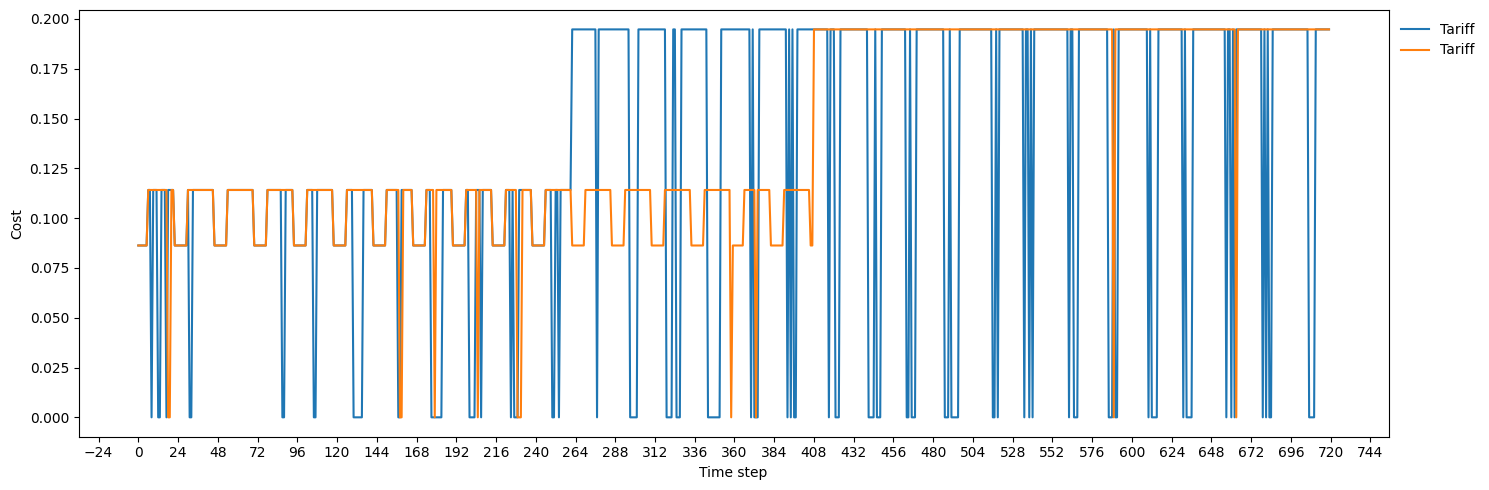

In [162]:
import matplotlib.ticker as ticker
%matplotlib inline

envs = {
    # 'DQN': dqn_env,
    'SAC': sac_env,
    # 'A2C': a2c_env,
    # 'DDPG': ddpg_env,
    # 'TD3': td3_env,
    # 'PPO': ppo_env
}

figsize = (15.0, 5)
fig, ax = plt.subplots(1, 1, figsize=figsize)

for k, v in envs.items():
    y = [cost / consumption if consumption != 0 else 0 for cost, consumption in zip(v.buildings[0].net_electricity_consumption_cost, v.buildings[0].net_electricity_consumption)]
    x = range(len(y))
    ax.plot(x, y, label='Tariff')
    y = [cost / consumption if consumption != 0 else 0 for cost, consumption in zip(v.buildings[1].net_electricity_consumption_cost, v.buildings[1].net_electricity_consumption)]
    x = range(len(y))
    ax.plot(x, y, label='Tariff')

ax.set_xlabel('Time step')
ax.set_ylabel('Cost')
ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)
# ax.set_ylim(0, 1)

plt.tight_layout()

In [ ]:
import pandas as pd

def get_kpis(env: CityLearnEnv) -> pd.DataFrame:
    """Returns evaluation KPIs.

    Electricity consumption, cost and carbon emissions KPIs are provided
    at the building-level and average district-level. Average daily peak,
    ramping and (1 - load factor) KPIs are provided at the district level.

    Parameters
    ----------
    env: CityLearnEnv
        CityLearn environment instance.

    Returns
    -------
    kpis: pd.DataFrame
        KPI table.
    """

    kpis = env.evaluate()

    # names of KPIs to retrieve from evaluate function
    kpi_names = [
        'electricity_consumption_total', 'cost_total', 'carbon_emissions_total',
        'daily_peak_average', 'ramping_average', 'monthly_one_minus_load_factor_average'
    ]
    kpis = kpis[
        (kpis['cost_function'].isin(kpi_names))
    ].dropna()

    # round up the values to 3 decimal places for readability
    kpis['value'] = kpis['value'].round(3)

    # rename the column that defines the KPIs
    kpis = kpis.rename(columns={'cost_function': 'kpi'})

    return kpis

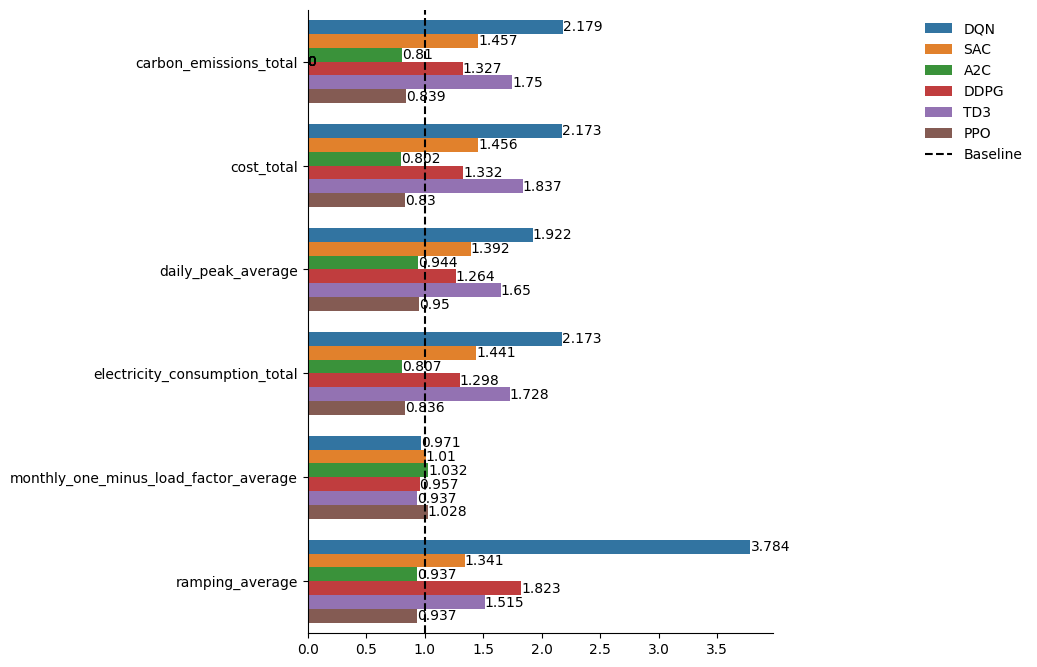

In [ ]:
import seaborn as sns

envs = {
    'DQN': dqn_env,
    'SAC': sac_env,
    'A2C': a2c_env,
    'DDPG': ddpg_env,
    'TD3': td3_env,
    'PPO': ppo_env
}

kpis_list = []

for k, v in envs.items():
    kpis = get_kpis(v)
    kpis = kpis[kpis['level']=='district'].copy()
    kpis['env_id'] = k
    kpis_list.append(kpis)

kpis = pd.concat(kpis_list, ignore_index=True, sort=False)
row_count = 1
column_count = 1
env_count = len(envs)
kpi_count = len(kpis['kpi'].unique())
figsize = (6.0*column_count, 0.225*env_count*kpi_count*row_count)
fig, ax = plt.subplots(row_count, column_count, figsize=figsize)
sns.barplot(x='value', y='kpi', data=kpis, hue='env_id', ax=ax)
ax.axvline(1.0, color='black', linestyle='--', label='Baseline')
ax.set_xlabel(None)
ax.set_ylabel(None)

for s in ['right','top']:
    ax.spines[s].set_visible(False)

for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width(),
        p.get_y() + p.get_height()/2.0,
        p.get_width(), ha='left', va='center'
    )

ax.legend(loc='upper left', bbox_to_anchor=(1.3, 1.0), framealpha=0.0)

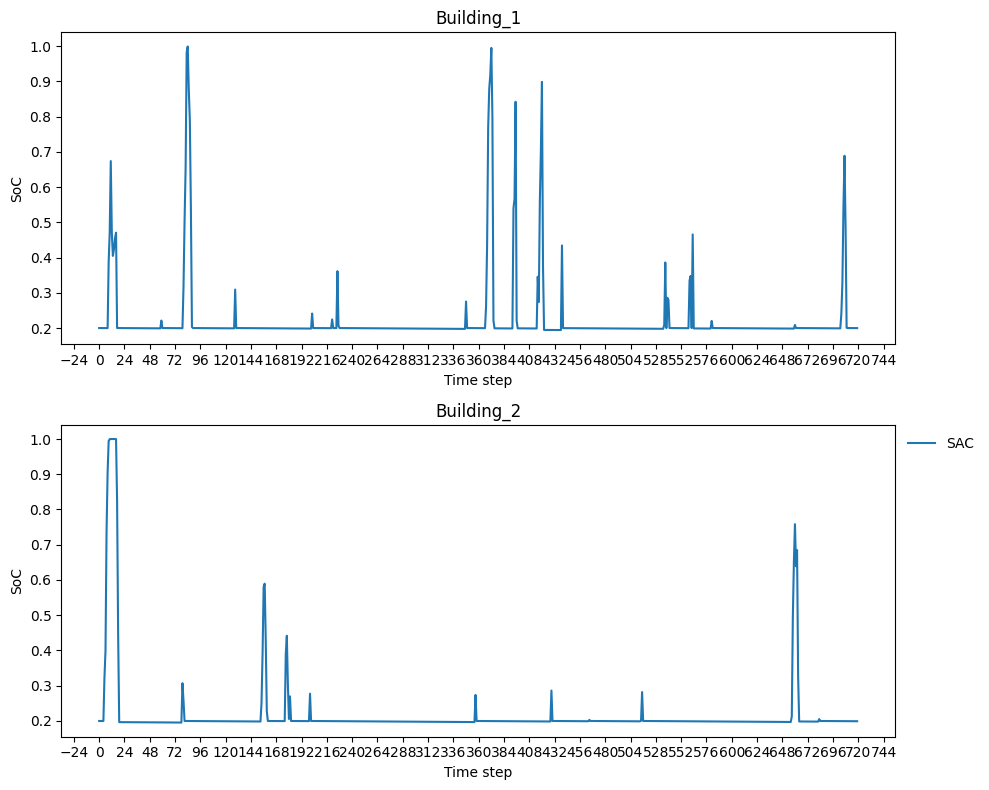

In [148]:
import math

envs = {
    # 'DQN': dqn_env,
    'SAC': sac_env,
    # 'A2C': a2c_env,
    # 'DDPG': ddpg_env,
    # 'TD3': td3_env,
    # 'PPO': ppo_env
}

building_count = len(list(envs.values())[0].buildings)
column_count_limit = 1
row_count = math.ceil(building_count/column_count_limit)
column_count = min(column_count_limit, building_count)
figsize = (10.0*column_count, 4*row_count)
fig, _ = plt.subplots(row_count, column_count, figsize=figsize)

for i, ax in enumerate(fig.axes):
    for k, v in envs.items():
        soc = np.array(v.buildings[i].electrical_storage.soc)
        capacity = v.buildings[i].electrical_storage.capacity_history[0]
        y = soc
        x = range(len(y))
        ax.plot(x, y, label=k)

    ax.set_title(v.buildings[i].name)
    ax.set_xlabel('Time step')
    ax.set_ylabel('SoC')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(24))

    if i == building_count - 1:
        ax.legend(
            loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0
        )
    else:
        ax.legend().set_visible(False)


plt.tight_layout()

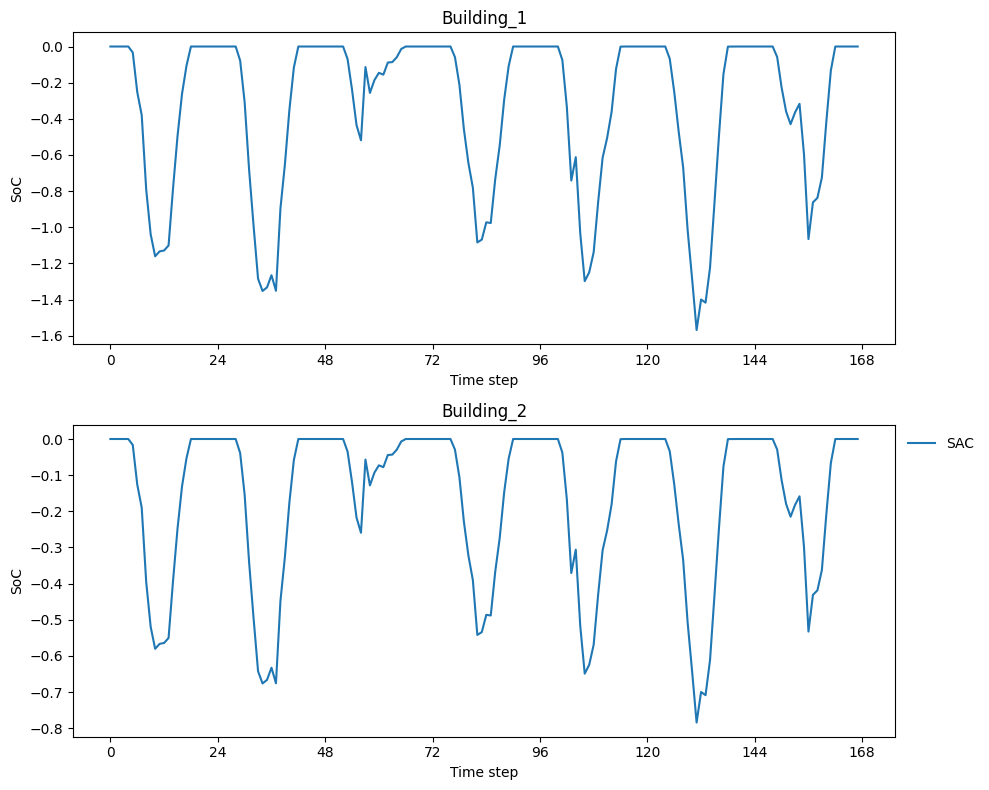

In [79]:
import math

envs = {
    # 'DQN': dqn_env,
    'SAC': sac_env,
    # 'A2C': a2c_env,
    # 'DDPG': ddpg_env,
    # 'TD3': td3_env,
    # 'PPO': ppo_env
}

building_count = len(list(envs.values())[0].buildings)
column_count_limit = 1
row_count = math.ceil(building_count/column_count_limit)
column_count = min(column_count_limit, building_count)
figsize = (10.0*column_count, 4*row_count)
fig, _ = plt.subplots(row_count, column_count, figsize=figsize)

for i, ax in enumerate(fig.axes):
    for k, v in envs.items():
        soc = np.array(v.buildings[i].solar_generation)
        capacity = v.buildings[i].electrical_storage.capacity_history[0]
        y = soc
        x = range(len(y))
        ax.plot(x, y, label=k)

    ax.set_title(v.buildings[i].name)
    ax.set_xlabel('Time step')
    ax.set_ylabel('SoC')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(24))

    if i == building_count - 1:
        ax.legend(
            loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0
        )
    else:
        ax.legend().set_visible(False)


plt.tight_layout()

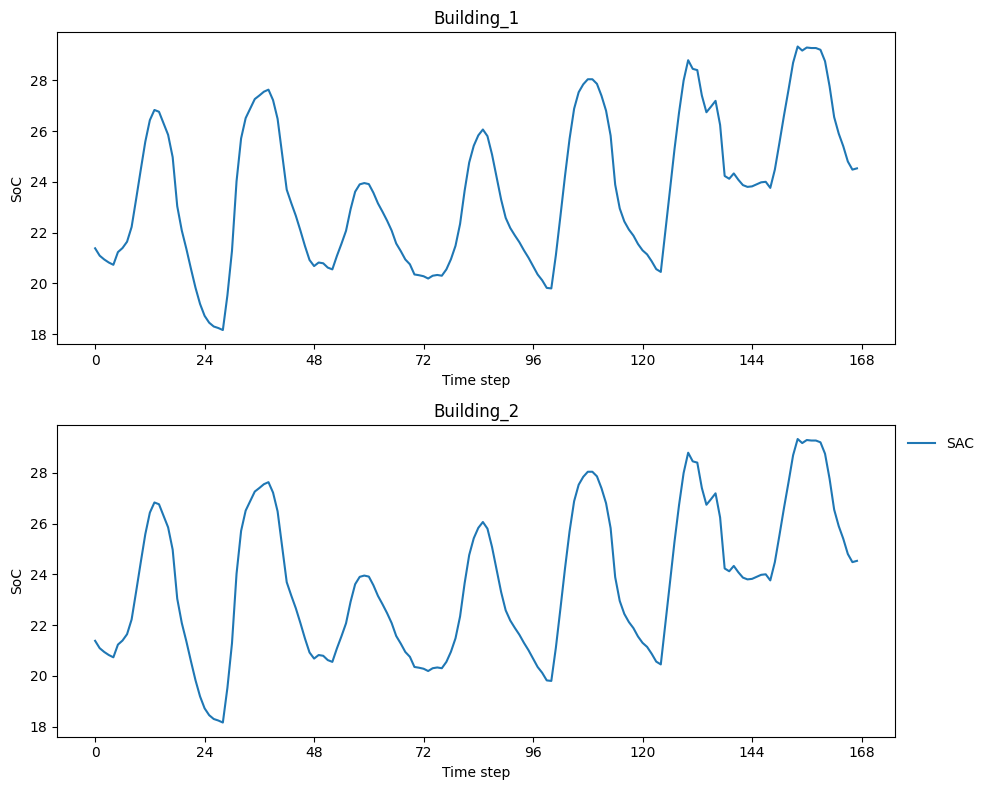

In [33]:
import math

envs = {
    # 'DQN': dqn_env,
    'SAC': sac_env,
    # 'A2C': a2c_env,
    # 'DDPG': ddpg_env,
    # 'TD3': td3_env,
    # 'PPO': ppo_env
}

building_count = len(list(envs.values())[0].buildings)
column_count_limit = 1
row_count = math.ceil(building_count/column_count_limit)
column_count = min(column_count_limit, building_count)
figsize = (10.0*column_count, 4*row_count)
fig, _ = plt.subplots(row_count, column_count, figsize=figsize)

for i, ax in enumerate(fig.axes):
    for k, v in envs.items():
        soc = np.array(v.buildings[i].weather.outdoor_dry_bulb_temperature)
        capacity = v.buildings[i].electrical_storage.capacity_history[0]
        y = soc
        x = range(len(y))
        ax.plot(x, y, label=k)

    ax.set_title(v.buildings[i].name)
    ax.set_xlabel('Time step')
    ax.set_ylabel('SoC')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(24))

    if i == building_count - 1:
        ax.legend(
            loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0
        )
    else:
        ax.legend().set_visible(False)


plt.tight_layout()

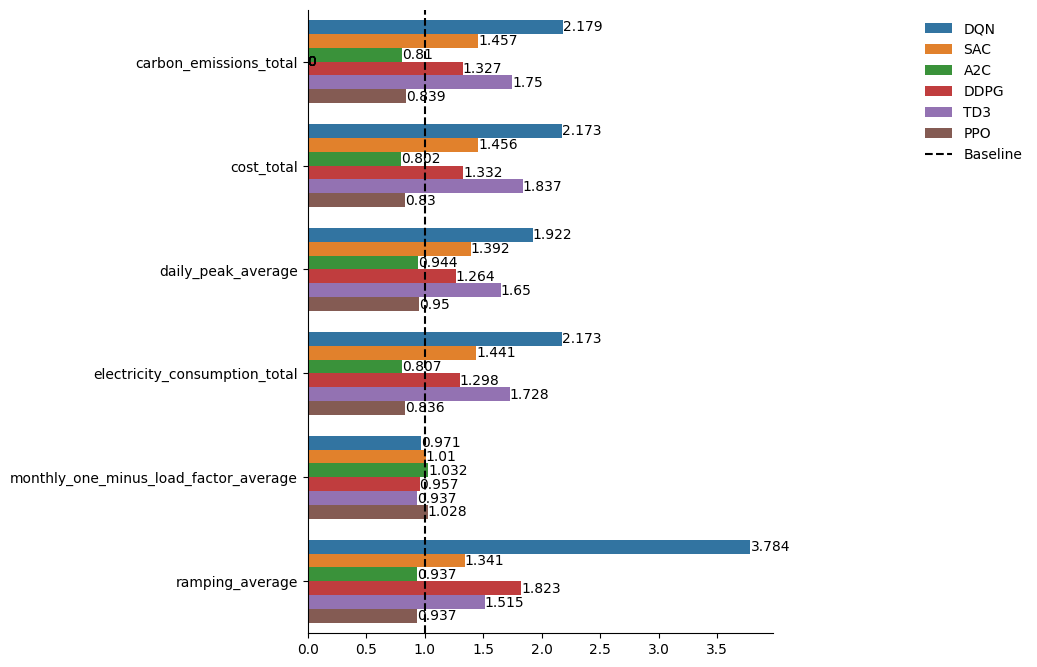

In [ ]:
import seaborn as sns

envs = {
    'DQN': dqn_env,
    # 'DQNR': dqnr_env,
    'SAC': sac_env,
    'A2C': a2c_env,
    'DDPG': ddpg_env,
    'TD3': td3_env,
    'PPO': ppo_env,
    # 'SACR': sacr_env
}

kpis_list = []

for k, v in envs.items():
    kpis = get_kpis(v)
    kpis = kpis[kpis['level']=='district'].copy()
    kpis['env_id'] = k
    kpis_list.append(kpis)

kpis = pd.concat(kpis_list, ignore_index=True, sort=False)
row_count = 1
column_count = 1
env_count = len(envs)
kpi_count = len(kpis['kpi'].unique())
figsize = (6.0*column_count, 0.225*env_count*kpi_count*row_count)
fig, ax = plt.subplots(row_count, column_count, figsize=figsize)
sns.barplot(x='value', y='kpi', data=kpis, hue='env_id', ax=ax)
ax.axvline(1.0, color='black', linestyle='--', label='Baseline')
ax.set_xlabel(None)
ax.set_ylabel(None)

for s in ['right','top']:
    ax.spines[s].set_visible(False)

for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width(),
        p.get_y() + p.get_height()/2.0,
        p.get_width(), ha='left', va='center'
    )

ax.legend(loc='upper left', bbox_to_anchor=(1.3, 1.0), framealpha=0.0)

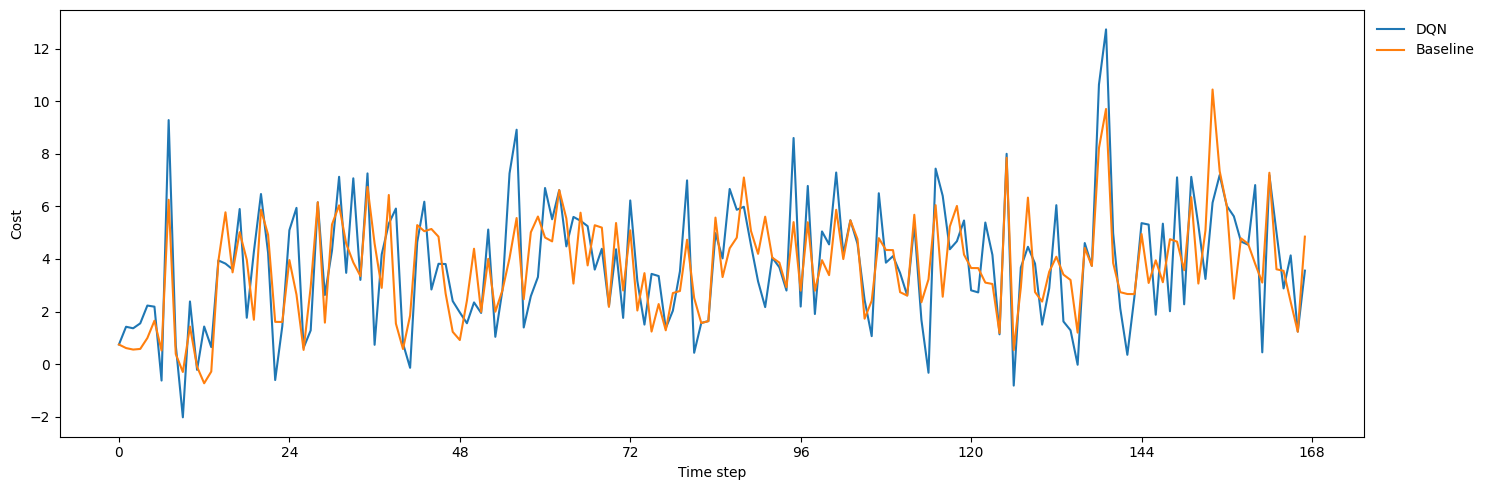

In [42]:
import matplotlib.ticker as ticker

envs = {
    # "DQNR": dqnr_env,
    'DQN': dqn_env,
    # 'SAC': sac_env,
    # 'A2C': a2c_env,
    # 'DDPG': ddpg_env,
    # 'TD3': td3_env,
    # 'PPO': ppo_env
}

figsize = (15.0, 5)
fig, ax = plt.subplots(1, 1, figsize=figsize)

for k, v in envs.items():
    y = v.net_electricity_consumption
    x = range(len(y))
    ax.plot(x, y, label=k)

y = v.net_electricity_consumption_without_storage
ax.plot(x, y, label='Baseline')
ax.set_xlabel('Time step')
ax.set_ylabel('Cost')
ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)

plt.tight_layout()

ValueError: x and y must have same first dimension, but have shapes (24,) and (0,)

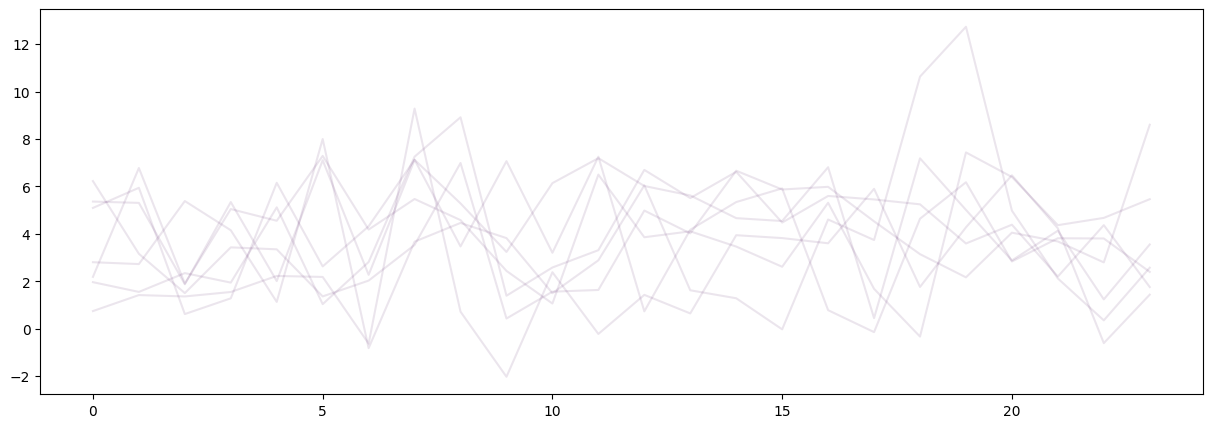

In [41]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

envs = {
    # "Baseline": rbc_env,
    # "DQNR": dqnr_env,
    'DQN': dqn_env,
    # 'SAC': sac_env,
    # 'A2C': a2c_env,
    # 'DDPG': ddpg_env,
    # 'TD3': td3_env,
    # 'PPO': ppo_env
}

figsize = (15.0, 5)
fig, ax = plt.subplots(1, 1, figsize=figsize)

# Calculate daily averages
daily_averages = np.zeros((len(envs), 24))
for i, (k, v) in enumerate(envs.items()):
    y = v.net_electricity_consumption
    for j in range(7):  # 7 days in a week
        daily_averages[i] += y[j*24:(j+1)*24]
    daily_averages[i] /= 7

x = range(24)  # 24 hours in a day
colors = plt.cm.viridis(np.linspace(0, 1, len(envs)))
# Plot individual daily lines with opacity
for i, (k, v) in enumerate(envs.items()):
    y = v.net_electricity_consumption
    color = colors[i]
    for j in range(30):  # 7 days in a week
        ax.plot(x, y[j*24:(j+1)*24], color=color, alpha=0.1)

# Plot thick average line
for i, (k, v) in enumerate(envs.items()):
    color = colors[i]
    ax.plot(x, daily_averages[i], color=color, label=f'{k} Daily Average', linewidth=2)

# Calculate and plot daily averages for the baseline
y_baseline = v.net_electricity_consumption_without_storage
baseline_daily_average = np.mean(y_baseline.reshape(-1, 24), axis=0)
ax.plot(range(24), baseline_daily_average, label='No Storage Daily Average', color='black', linewidth=2)

ax.set_xlabel('Time step (hours)')
ax.set_ylabel('Cost')
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))  # Show ticks every 3 hours
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)

plt.tight_layout()
plt.show()

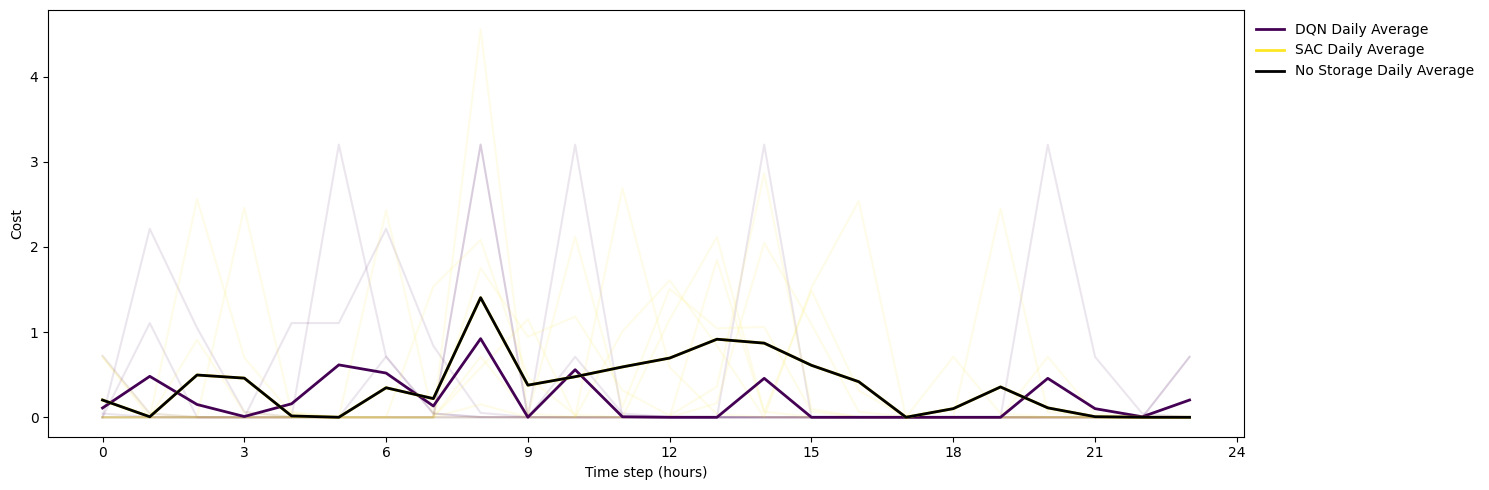

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

envs = {
    # "RBC": rbc_env,
    # "DQNR": dqnr_env,
    'DQN': dqn_env,
    'SAC': sac_env,
    # 'A2C': a2c_env,
    # 'DDPG': ddpg_env,
    # 'TD3': td3_env,
    # 'PPO': ppo_env
}

figsize = (15.0, 5)
fig, ax = plt.subplots(1, 1, figsize=figsize)

# Calculate daily averages
daily_averages = np.zeros((len(envs), 24))
for i, (k, v) in enumerate(envs.items()):
    y = v.energy_to_electrical_storage
    for j in range(7):  # 7 days in a week
        daily_averages[i] += y[j*24:(j+1)*24]
    daily_averages[i] /= 7

x = range(24)  # 24 hours in a day
colors = plt.cm.viridis(np.linspace(0, 1, len(envs)))
# Plot individual daily lines with opacity
for i, (k, v) in enumerate(envs.items()):
    y = v.energy_to_electrical_storage
    color = colors[i]
    for j in range(7):  # 7 days in a week
        ax.plot(x, y[j*24:(j+1)*24], color=color, alpha=0.1)

# Plot thick average line
for i, (k, v) in enumerate(envs.items()):
    color = colors[i]
    ax.plot(x, daily_averages[i], color=color, label=f'{k} Daily Average', linewidth=2)

# Calculate and plot daily averages for the baseline
y_baseline = v.energy_to_electrical_storage
baseline_daily_average = np.mean(y_baseline.reshape(-1, 24), axis=0)
ax.plot(range(24), baseline_daily_average, label='No Storage Daily Average', color='black', linewidth=2)

ax.set_xlabel('Time step (hours)')
ax.set_ylabel('Cost')
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))  # Show ticks every 3 hours
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)

plt.tight_layout()
plt.show()